In [92]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
import pickle
import re
import math
from utils import *

In [93]:
test_img_paths = glob.glob('test_images/test*.jpg')

video1 = glob.glob('video_frames/frame*.jpg')

video2 = glob.glob('video_frames_1/frame*.jpg')

# List of all demos to visualise
plot_demo = [1, 2, 3, 4, 5, 6, 7, 8]

In [94]:
def calibrate_camera():
    
    imgpaths = glob.glob('camera_cal/cal_*.png')
    
    image = cv2.imread(imgpaths[0])
    imshape = image.shape[:2] # gets only the (height, width) to be used in the cv2.calibrateCamera()
   
    objpoints = []
    imgpoints = []

    nx = 10 # Number of inside corners on each row of the chessboard
    ny = 5 # Number of inside corners on each column of the chessboard

    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros([ny*nx, 3], dtype=np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)


    img = cv2.imread(imgpaths[0])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret:
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

        imgpoints.append(corners)
        objpoints.append(objp)

        cv2.imshow('img', img)
        cv2.waitKey(500)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imshape[::-1], None, None)
   
    cv2.destroyAllWindows()
    return mtx, dist


In [95]:
if os.path.exists('camera_cal.p'):
    with open('camera_cal.p', mode='rb') as f:
        data = pickle.load(f)
        mtx, dist = data['mtx'], data['dist']
        print('Loaded the saved camera calibration matrix & dist coefficients!')
else:
    mtx, dist = calibrate_camera()
    with open('camera_cal.p', mode='wb') as f:
        pickle.dump({'mtx': mtx, 'dist': dist}, f)

Loaded the saved camera calibration matrix & dist coefficients!


In [96]:
def undistort(img, mtx, dist): 
    undistort = cv2.undistort(img, mtx, dist, None, mtx)
    return undistort

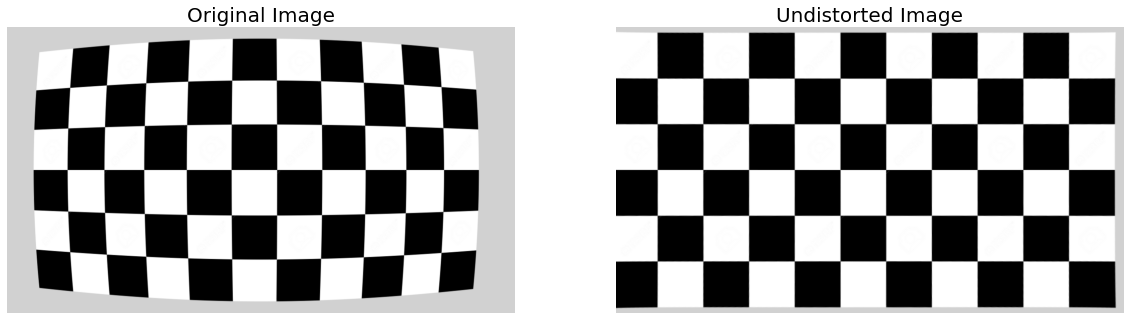

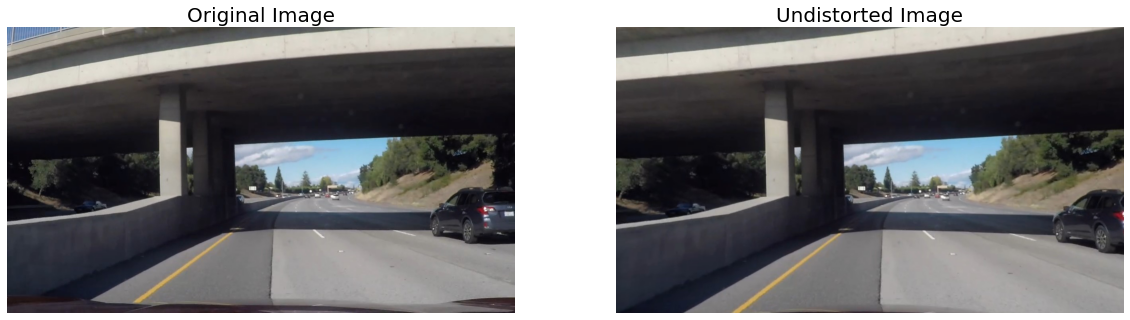

In [97]:
if 1 in plot_demo:
    cal_img = cv2.imread('camera_cal/cal_01.png')
    cal_img_undist = undistort(cal_img, mtx, dist)

    plot_imgs([
        (cal_img, 'Original Image'),
        (cal_img_undist, 'Undistorted Image')
    ])
    
    img_orig = mpimg.imread(test_img_paths[8])
    img = undistort(img_orig, mtx, dist)

    plot_imgs([
        (img_orig, 'Original Image'),
        (img, 'Undistorted Image')
    ])

In [70]:
IMG_SHAPE = (720, 1280)

def get_roi(img, vertices):
    vertices = np.array(vertices, ndmin=3, dtype=np.int32)
    if len(img.shape) == 3:
        fill_color = (255,) * 3
    else:
        fill_color = 255
            
    mask = np.zeros_like(img)
    mask = cv2.fillPoly(mask, vertices, fill_color)
    return cv2.bitwise_and(img, mask)
    
def warp_image(img, warp_shape, src, dst):
    
    # Get the perspective transformation matrix and its inverse
    M = cv2.getPerspectiveTransform(src, dst)
    invM = cv2.getPerspectiveTransform(dst, src)
    
    # Warp the image
    warped = cv2.warpPerspective(img, M, warp_shape, flags=cv2.INTER_LINEAR)
    return warped, M, invM

def preprocess_image(img, visualise=False):   
    ysize = img.shape[0]
    xsize = img.shape[1]
    
    x_offset = 0.015
    x1_ratio = 0.18
    x2_ratio = 0.46
    
    y1_ratio = 0.63
    y2_ratio = 0.95
    
    # 1. Distortion correction
    undist = undistort(img, mtx, dist)
    
    # 2. Perspective transformation
    src = np.float32([
        (((1-x2_ratio)) * xsize, y1_ratio * ysize),    
        ((x2_ratio) * xsize, y1_ratio * ysize), 
        ((x1_ratio + x_offset) * xsize, y2_ratio * ysize),  
        (((1-x1_ratio) + x_offset) * xsize, y2_ratio * ysize)
    ])

    dst = np.float32([
        (xsize * (1 - ((x1_ratio + x2_ratio) / 2)), 0),
        (xsize * ((x1_ratio + x2_ratio) / 2), 0),
        (xsize * ((x1_ratio + x2_ratio) / 2), ysize),
        (xsize * (1 - ((x1_ratio + x2_ratio) / 2)), ysize)
    ])

    warped, M, invM = warp_image(undist, (xsize, ysize), src, dst)

    # 3. ROI crop
    vertices = np.array([
        [200, ysize],
        [200, 0],
        [1100, 0],
        [1100, ysize]
    ])

    roi = get_roi(warped, vertices)

    # 4. Visualise the transformation
    if visualise:
        img_copy = np.copy(img)
        roi_copy = np.copy(roi)
        
        cv2.polylines(img_copy, [np.int32(src)], True, (0, 255, 200), 3)
        cv2.polylines(roi_copy, [np.int32(dst)], True, (0, 255, 200), 3)
        
        plot_imgs([
            (img_copy, 'Original Image'),
            (roi_copy, 'Bird\'s Eye View Perspective')
        ])

    return roi, (M, invM)

def get_image(img_path, visualise=False):
    img = mpimg.imread(img_path)
    return preprocess_image(img, visualise=visualise)

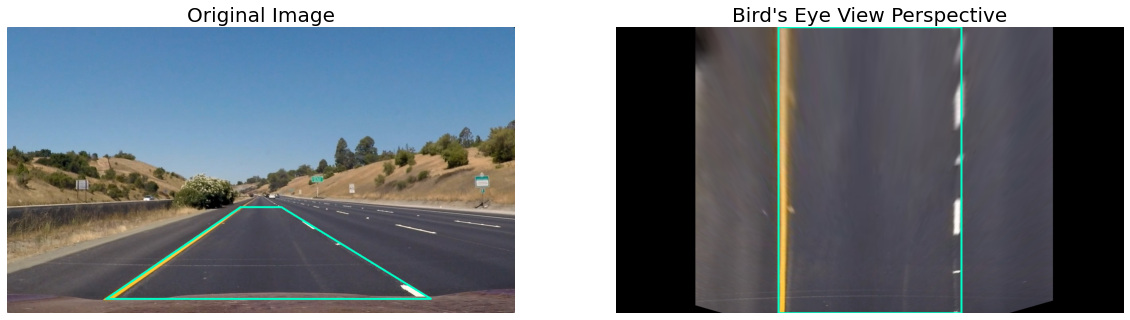

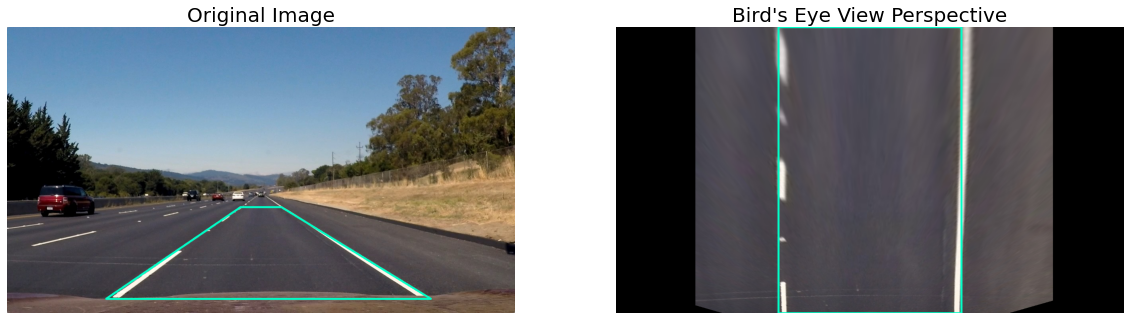

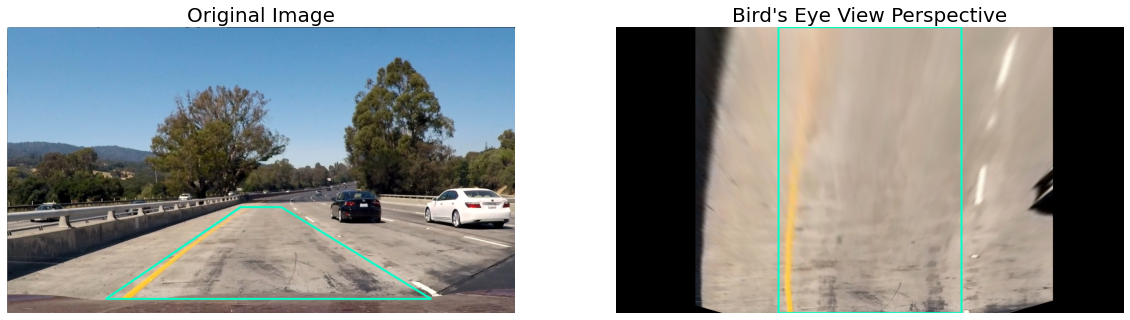

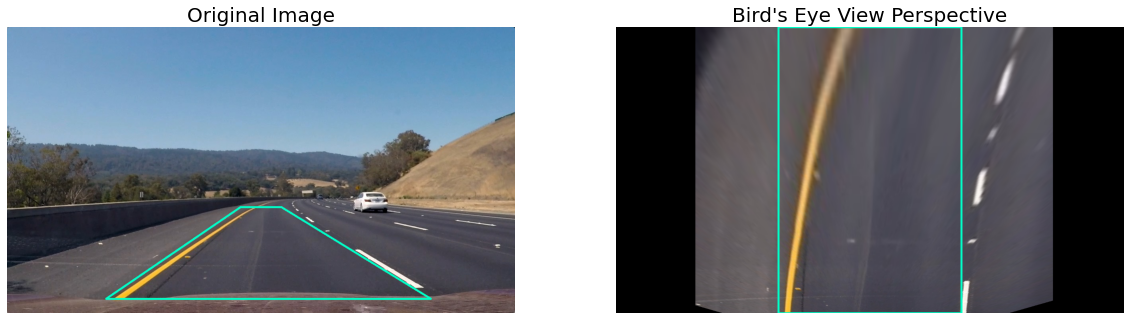

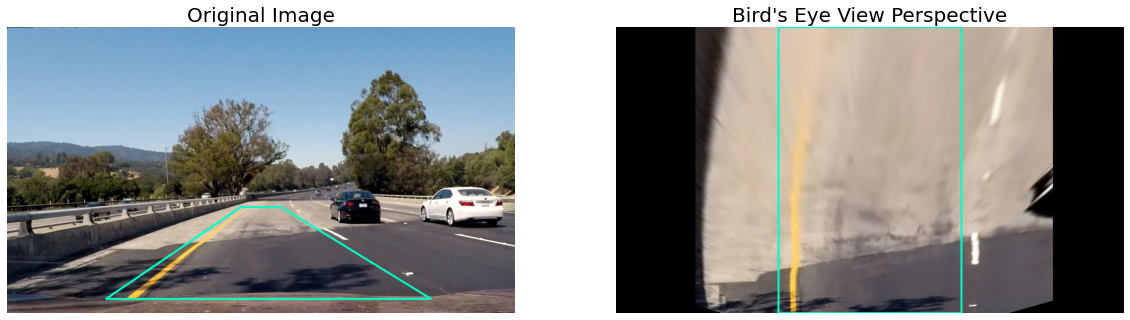

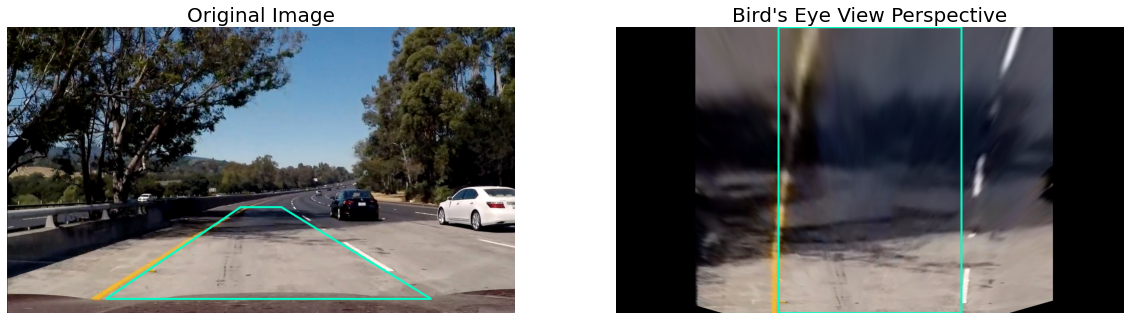

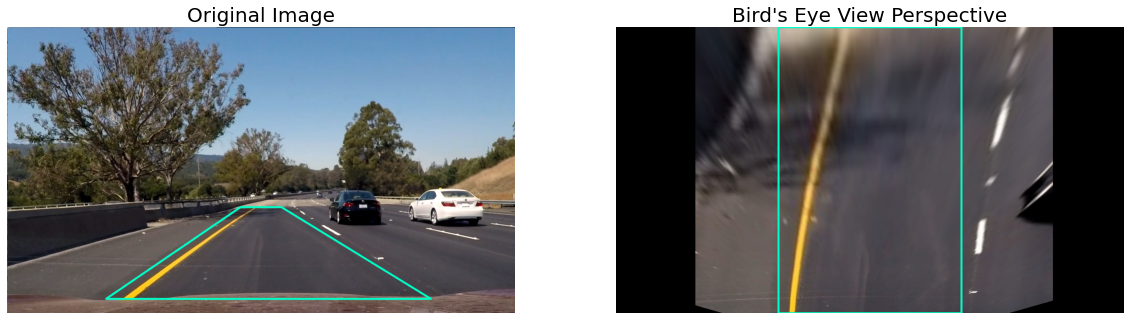

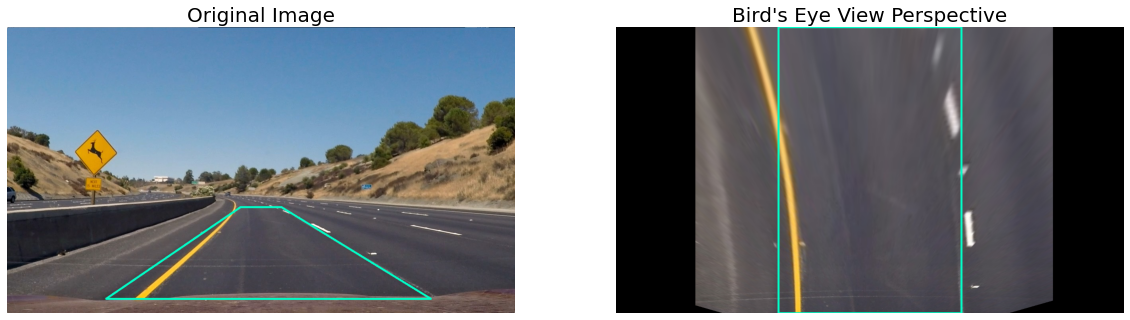

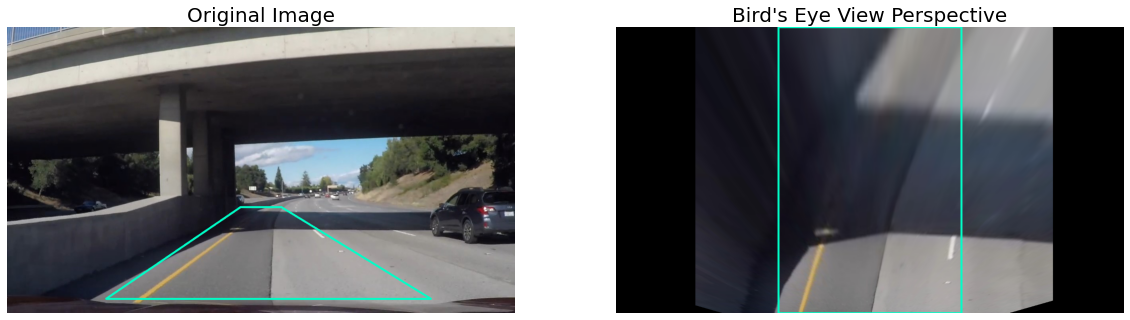

In [71]:
if 2 in plot_demo:
    for path in test_img_paths[:]:
        get_image(path, visualise=True)

In [ ]:
def binary_threshold(img, low, high):    
    if len(img.shape) == 2:
        output = np.zeros_like(img)
        mask = (img >= low) & (img <= high)
        
    elif len(img.shape) == 3:
        output = np.zeros_like(img[:,:,0])
        mask = (img[:,:,0] >= low[0]) & (img[:,:,0] <= high[0]) \
            & (img[:,:,1] >= low[1]) & (img[:,:,1] <= high[1]) \
            & (img[:,:,2] >= low[2]) & (img[:,:,2] <= high[2])
            
    output[mask] = 1
    return output

In [ ]:
def get_binary_image(img, visualise=False):
    ### LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    L = lab[:,:,0]
    L_max, L_mean = np.max(L), np.mean(L)
    B = lab[:,:,2]
    B_max, B_mean = np.max(B), np.mean(B)

    # YELLOW
    L_adapt_yellow = max(80, int(L_max * 0.45))
    B_adapt_yellow =  max(int(B_max * 0.70), int(B_mean * 1.2))
    lab_low_yellow = np.array((L_adapt_yellow, 120, B_adapt_yellow))
    lab_high_yellow = np.array((255, 145, 255))

    lab_yellow = binary_threshold(lab, lab_low_yellow, lab_high_yellow)
    lab_binary = lab_yellow
      
    ### HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    H = hsv[:,:,0]
    H_max, H_mean = np.max(H), np.mean(H)
    S = hsv[:,:,1]
    S_max, S_mean = np.max(S), np.mean(S)
    V = hsv[:,:,2]
    V_max, V_mean = np.max(V), np.mean(V)
    
    # YELLOW
    S_adapt_yellow =  max(int(S_max * 0.25), int(S_mean * 1.75))
    V_adapt_yellow =  max(70, int(V_mean * 1.25))
    hsv_low_yellow = np.array((15, S_adapt_yellow, V_adapt_yellow))
   
    hsv_high_yellow = np.array((30, 255, 255))
    hsv_yellow = binary_threshold(hsv, hsv_low_yellow, hsv_high_yellow)    

    # WHITE
    V_adapt_white = max(150, int(V_max * 0.8),int(V_mean * 1.25))
    hsv_low_white = np.array((0, 0, V_adapt_white))
    hsv_high_white = np.array((255, 40, 255))

    hsv_white = binary_threshold(hsv, hsv_low_white, hsv_high_white)

    hsv_binary = hsv_yellow | hsv_white

    ### HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    L = hls[:,:,1]
    L_max, L_mean = np.max(L), np.mean(L)
    S = hls[:,:,2]
    S_max, S_mean = np.max(S), np.mean(S)
 
    # YELLOW
    L_adapt_yellow = max(80, int(L_mean * 1.25))
    S_adapt_yellow = max(int(S_max * 0.25), int(S_mean * 1.75))
    hls_low_yellow = np.array((15, L_adapt_yellow, S_adapt_yellow))
    hls_high_yellow = np.array((30, 255, 255))

    hls_yellow = binary_threshold(hls, hls_low_yellow, hls_high_yellow)
    
    # WHITE
    L_adapt_white =  max(160, int(L_max *0.8),int(L_mean * 1.25))
    hls_low_white = np.array((0, L_adapt_white,  0))
    hls_high_white = np.array((255, 255, 255))

    hls_white = binary_threshold(hls, hls_low_white, hls_high_white)
        
    hls_binary = hls_yellow | hls_white

    ### R color channel (WHITE)
    R = img[:,:,0]
#     R = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)[:,:,0]
    R_max, R_mean = np.max(R), np.mean(R)
    
    R_low_white = min(max(150, int(R_max * 0.55), int(R_mean * 1.95)),230)
    R_binary = binary_threshold(R, R_low_white, 255)
    
    B = img[:,:,2]
    B_max, B_mean = np.max(B), np.mean(B)
    
    B_low_white = min(max(160, int(B_max * 0.5), int(B_mean * 1.95)),210)
    B_binary = binary_threshold(B, B_low_white, 255)
    
    ### Adaptive thresholding: Gaussian kernel 
    # YELLOW
    
    adapt_yellow_S = cv2.adaptiveThreshold(hls[:,:,2], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -5)
    adapt_yellow_B = cv2.adaptiveThreshold(lab[:,:,2], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -5)
    adapt_yellow = adapt_yellow_S & adapt_yellow_B
    
    # WHITE
    adapt_white_R = cv2.adaptiveThreshold(img[:,:,0], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -27)
    adapt_white_V = cv2.adaptiveThreshold(hsv[:,:,2], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -27)
    adapt_white = adapt_white_R & adapt_white_V
    
                                                  
    adapt_binary =  adapt_yellow | adapt_white
    

    ### Ensemble Voting
    combined = np.asarray(lab_binary + hls_binary + hsv_binary + adapt_binary + B_binary, dtype=np.uint8)

    combined[combined < 3] = 0
    combined[combined >= 3] = 1

    if visualise:
        plot_imgs([
            (img, 'Original'),
#             (R_binary, 'R'),
            (B_binary, 'B'),
            (hls_binary, 'HLS'),
            (hsv_binary, 'HSV'),
            (lab_binary, 'LAB'),
            (adapt_binary, 'Adaptive Thresh'),
            (combined, 'Combined'),
#             (hls_white, 'hls_white'),
#             (hls_yellow, 'hls yellow'),
#             (lab_yellow, 'lab yello'),
        ], figsize=(32, 42))

    return  combined

In [ ]:
if 3 in plot_demo:
    for img_path in test_img_paths[:9]: #video2[5:10]:
        img, _ = get_image(img_path)
        get_binary_image(img, visualise=True)

In [ ]:
def get_poly_points(left_fit, right_fit):
    ysize, xsize = IMG_SHAPE
    
    # Get the points for the entire height of the image
    plot_y = np.linspace(0, ysize-1, ysize)
    plot_xleft = left_fit[0] * plot_y**2 + left_fit[1] * plot_y + left_fit[2]
    plot_xright = right_fit[0] * plot_y**2 + right_fit[1] * plot_y + right_fit[2]
    
    # But keep only those points that lie within the image
    plot_xleft = plot_xleft[(plot_xleft >= 0) & (plot_xleft <= xsize - 1)]
    plot_xright = plot_xright[(plot_xright >= 0) & (plot_xright <= xsize - 1)]
    plot_yleft = np.linspace(ysize - len(plot_xleft), ysize - 1, len(plot_xleft))
    plot_yright = np.linspace(ysize - len(plot_xright), ysize - 1, len(plot_xright))
    
    return plot_xleft.astype(np.int), plot_yleft.astype(np.int), plot_xright.astype(np.int), plot_yright.astype(np.int)

def check_validity(left_fit, right_fit, diagnostics=False):
    
    if left_fit is None or right_fit is None:
        return False
    
    plot_xleft, plot_yleft, plot_xright, plot_yright = get_poly_points(left_fit, right_fit)

    # Check whether the two lines lie within a plausible distance from one another for three distinct y-values

    y1 = IMG_SHAPE[0] - 1 # Bottom
    y2 = IMG_SHAPE[0] - int(min(len(plot_yleft), len(plot_yright)) * 0.35) # For the 2nd and 3rd, take values between y1 and the top-most available value.
    y3 = IMG_SHAPE[0] - int(min(len(plot_yleft), len(plot_yright)) * 0.75)


    # Check whether the line slopes are similar for two distinct y-values
    # x = Ay**2 + By + C
    # dx/dy = 2Ay + B
    
    y1left_dx  = 2 * left_fit[0]  * y1 + left_fit[1]
    y3left_dx  = 2 * left_fit[0]  * y3 + left_fit[1]
    y1right_dx = 2 * right_fit[0] * y1 + right_fit[1]
    y3right_dx = 2 * right_fit[0] * y3 + right_fit[1]

    # Compute the L1-norm
    norm1 = abs(y1left_dx - y1right_dx)
    norm2 = abs(y3left_dx - y3right_dx)
    
#     if diagnostics: print( norm1, norm2)

    # Define the L1 norm threshold
    thresh = 0.6 #0.45 #0.58 
    if (norm1 >= thresh) | (norm2 >= thresh):
        if diagnostics:
            print("Violated tangent criterion: " +
                  "norm1 == {:.3f}, norm2 == {:.3f} (thresh == {}).".format(norm1, norm2, thresh))
            return False
    
    return True

In [ ]:
def polyfit_sliding_window(binary, lane_width_px=578, visualise=False, diagnostics=False):
    
    global cache
    ret = True

    # Sanity check
    if binary.max() <= 0:
        return False, np.array([]), np.array([]), np.array([])
    
    # Step 1: Compute the histogram along all the columns in the lower half of the image. 
    # The two most prominent peaks in this histogram will be good indicators of the
    # x-position of the base of the lane lines
    histogram = None
    
    cutoffs = [int(binary.shape[0] / 2), 0]
    
    for cutoff in cutoffs:
        histogram = np.sum(binary[cutoff:, :], axis=0)
        
        
        if histogram.max() > 0:
            break

    if histogram.max() == 0:
        print('Unable to detect lane lines in this frame. Trying another frame!')
        return False, np.array([]), np.array([])
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    if visualise:
        plot_imgs([(binary, 'Binary')])
        plt.plot(histogram, 'm', linewidth=4.0)
        plt.plot((midpoint, midpoint), (0, IMG_SHAPE[0]), 'c')
        plt.plot((0, IMG_SHAPE[1]), (cutoff, cutoff), 'c')

    out = np.dstack((binary, binary, binary)) * 255

    nb_windows = 12 # number of sliding windows
    margin = 100 # width of the windows +/- margin
    minpix = 50 # min number of pixels needed to recenter the window
    window_height = int(IMG_SHAPE[0] / nb_windows)
    min_lane_pts = 10  # min number of 'hot' pixels needed to fit a 2nd order polynomial as a 
                    # lane line
    
    # Identify the x-y positions of all nonzero pixels in the image
    # Note: the indices here are equivalent to the coordinate locations of the
    # pixel
    nonzero = binary.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nb_windows):
        # Identify window boundaries in x and y (and left and right)
        win_y_low = IMG_SHAPE[0] - (1 + window) * window_height
        win_y_high = IMG_SHAPE[0] - window * window_height

        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin

        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw windows for visualisation
        cv2.rectangle(out, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high),\
                      (0, 255, 0), 2)
        cv2.rectangle(out, (win_xright_low, win_y_low), (win_xright_high, win_y_high),\
                      (0, 255, 0), 2)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)
                         & (nonzerox >= win_xleft_low) & (nonzerox <= win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)
                         & (nonzerox >= win_xright_low) & (nonzerox <= win_xright_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) >  minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))

        if len(good_right_inds) > minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract pixel positions for the left and right lane lines
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit, right_fit = None, None
    
    # Sanity check; Fit a 2nd order polynomial for each lane line pixels
    if len(leftx) >= min_lane_pts and len(rightx) >= min_lane_pts:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    
    # Validate detected lane lines
    valid = check_validity(left_fit, right_fit, diagnostics=diagnostics)
   
    if not valid:
        # If the detected lane lines are NOT valid:
        # 1. Compute the lane lines as an average of the previously detected lines
        # from the cache and flag this detection cycle as a failure by setting ret=False
        # 2. Else, if cache is empty, return 
        
        if len(cache) == 0:
            if diagnostics: print('WARNING: Unable to detect lane lines in this frame.')
            return False, np.array([]), np.array([])
        
        avg_params = np.mean(cache, axis=0)
        left_fit, right_fit = avg_params[0], avg_params[1]
        ret = False
        
    plot_xleft, plot_yleft, plot_xright, plot_yright = get_poly_points(left_fit, right_fit)

    # Color the detected pixels for each lane line
    out[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [255, 10, 255]

    left_poly_pts = np.array([np.transpose(np.vstack([plot_xleft, plot_yleft]))])
    right_poly_pts = np.array([np.transpose(np.vstack([plot_xright, plot_yright]))])

    # Plot the fitted polynomial
    cv2.polylines(out, np.int32([left_poly_pts]), isClosed=False, color=(200,255,155), thickness=4)
    cv2.polylines(out, np.int32([right_poly_pts]), isClosed=False, color=(200,255,155), thickness=4)

    if visualise:
        plot_imgs([(img, 'Original'), (out, 'Out')], figsize=(30, 40))
        
    return ret, out, np.array([left_fit, right_fit])

In [ ]:
if 4 in plot_demo:

    cache = np.array([])

    for img_path in test_img_paths[:]: #video2[134:138]:
        img, _ = get_image(img_path)
        binary = get_binary_image(img, visualise=False)
        polyfit_sliding_window(binary, visualise=True, diagnostics=True)

In [ ]:
def polyfit_adapt_search(img, prev_poly_param, visualise=False, diagnostics=False):
    
    global cache # Cache of the previosuly detected lane line coefficients
    global attempts # Number of retries before the pipeline is RESET to detect lines via the smoothing window aproach
    
    # Sanity check
    assert(len(img.shape) == 3)
    
    # Setup
    nb_windows = 10 # Number of windows over which to perform the localised color thresholding  
    bin_margin = 80 # Width of the windows +/- margin for localised thresholding
    margin = 60 # Width around previous line positions +/- margin around which to search for the new lines
    window_height = int(img.shape[0] / nb_windows)
    smoothing_window = 5 # Number of frames over which to compute the Moving Average
    min_lane_pts = 10
    
    binary = np.zeros_like(img[:,:,0]) # Placeholder for the thresholded binary image
    img_plot = np.copy(img)
        
    left_fit, right_fit = prev_poly_param[0], prev_poly_param[1]
    plot_xleft, plot_yleft, plot_xright, plot_yright = get_poly_points(left_fit, right_fit)
    
    leftx_current = np.int(plot_xleft[-1])
    rightx_current = np.int(plot_xright[-1])
    
    # Iterate over the windows, perform localised color thresholding and generate the binary image
    for window in range(nb_windows):
        # Identify window boundaries in x and y (and left and right)
        win_y_low = IMG_SHAPE[0] - (window + 1) * window_height
        win_y_high = IMG_SHAPE[0] - window * window_height
        win_xleft_low = min(max(0, leftx_current - bin_margin), 1280)
        win_xleft_high = min(max(0, leftx_current + bin_margin), 1280)
        win_xright_low = min(max(0, rightx_current - bin_margin), 1280)
        win_xright_high = min(max(0, rightx_current + bin_margin), 1280)

        img_win_left = img[win_y_low:win_y_high, win_xleft_low:win_xleft_high,:]
        binary[win_y_low:win_y_high, win_xleft_low:win_xleft_high] = \
            get_binary_image(img_win_left, visualise=False)

        img_win_right = img[win_y_low:win_y_high, win_xright_low:win_xright_high, :]
        binary[win_y_low:win_y_high, win_xright_low:win_xright_high] = \
            get_binary_image(img_win_right, visualise=False)

        # Given that we only keep the points/values for a line that lie within the image
        # (see 'get_poly_points'), the overall length and consequently number of points (i.e. x-values
        # and y-values) can be < the length of the image. As a result, we check for the presence
        # of the current window's lower y-value i.e 'win_y_low' as a valid point within the previously detected line
        # If, a point associated with this y-value exists, we update the x-position of the next window with
        # the corresponding x-value.
        # Else, we keep the x-position of the subsequent windows the same and move up the image
        idxs = np.where(plot_yleft == win_y_low)[0]
        if len(idxs) != 0:
            leftx_current = int(plot_xleft[idxs[0]])
            
        idxs = np.where(plot_yright == win_y_low)[0]
        if len(idxs) != 0:
            rightx_current = int(plot_xright[idxs[0]])

        if visualise:
            left_pts = np.array([np.transpose(np.vstack([plot_xleft, plot_yleft]))])
            right_pts = np.array([np.transpose(np.vstack([plot_xright, plot_yright]))])
            
            # Plot the previously detected lane lines
            cv2.polylines(img_plot, np.int32([left_pts]), isClosed=False, color=(255, 20, 147), thickness=4)
            cv2.polylines(img_plot, np.int32([right_pts]), isClosed=False, color=(255, 20, 147), thickness=4)    
            
            bin_win_left = binary[win_y_low:win_y_high, win_xleft_low:win_xleft_high]
            bin_win_left = np.dstack((bin_win_left, np.zeros_like(bin_win_left), np.zeros_like(bin_win_left))) * 255

            bin_win_right = binary[win_y_low:win_y_high, win_xright_low:win_xright_high]
            bin_win_right = np.dstack([np.zeros_like(bin_win_right), np.zeros_like(bin_win_right), bin_win_right]) * 255
            
            # Blend the localised image window with its corresponding thresholded binary version
            win_left = cv2.addWeighted(bin_win_left, 0.5, img_win_left, 0.7, 0)
            win_right = cv2.addWeighted(bin_win_right, 0.5, img_win_right, 0.7, 0)
            
            # Draw the binary search window
            cv2.rectangle(img_plot, (win_xleft_low,win_y_low), (win_xleft_high,win_y_high), (0,255,0), 5)
            cv2.rectangle(img_plot, (win_xright_low,win_y_low), (win_xright_high,win_y_high), (0,255,0), 5)
            
            f, _ = plt.subplots(1, 2, figsize=(13,5))

            plt.subplot(121)
            plt.axis('off')
            plt.imshow(binary, cmap='gray')

            plt.subplot(122)
            plt.axis('off')
            plt.imshow(img_plot)

            plt.subplots_adjust(top=0.98, bottom=0.0, left=0.0, right=1.0, hspace=0.1, wspace=0.05)
            plt.savefig('./gif_images/window1{:02}.png'.format(window))
            
            # The blended Binary window and Image window is added later for better visualisation
            img_plot[win_y_low:win_y_high, win_xleft_low:win_xleft_high] = win_left
            img_plot[win_y_low:win_y_high, win_xright_low:win_xright_high] = win_right
        
    # Identify the x-y coordinates of all the non-zero pixels from the binary image
    # generated above
    nonzero = binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Extract all the 
    left_lane_inds = \
        ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) &
        (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = \
        ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) &
         (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Sanity checks
    if len(leftx) > min_lane_pts:
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        if diagnostics: print('WARNING: Less than {} pts detected for the left lane. {}'.format(min_lane_pts, len(leftx)))

    if len(rightx) > min_lane_pts:
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        if diagnostics: print('WARNING: Less than {} pts detected for the right lane. {}'.format(min_lane_pts, len(rightx)))
        
    valid = check_validity(left_fit, right_fit, diagnostics=diagnostics)

    # Perform smoothing via moving average
    if valid:
        if len(cache) < smoothing_window:
            cache = np.concatenate((cache, [np.array([left_fit, right_fit])]), axis=0)
        elif len(cache) >= smoothing_window:
            cache[:-1] = cache[1:]
            cache[-1] = np.array([left_fit, right_fit])

        avg_params = np.mean(cache, axis=0)
        left_fit, right_fit = avg_params[0], avg_params[1]
        plot_xleft, plot_yleft, plot_xright, plot_yright = get_poly_points(left_fit, right_fit)
        curr_poly_param = np.array([left_fit, right_fit])
    else:
        attempts += 1
        curr_poly_param = prev_poly_param
    
    out = np.dstack([binary, binary, binary]) * 255
    win_img = np.zeros_like(out)

    # Color the lane line pixels
    out[lefty, leftx] = [255, 0, 0]
    out[righty, rightx] = [255, 10, 255]

    left_window1 = np.array([np.transpose(np.vstack([plot_xleft - margin, plot_yleft]))])
    left_window2 = np.array([np.flipud(np.transpose(np.vstack([plot_xleft + margin, plot_yleft])))])
    left_pts = np.hstack([left_window1, left_window2])

    right_window1 = np.array([np.transpose(np.vstack([plot_xright - margin, plot_yright]))])
    right_window2 = np.array([np.flipud(np.transpose(np.vstack([plot_xright + margin, plot_yright])))])
    right_pts = np.hstack([right_window1, right_window2])

    # Draw the search boundary
    cv2.fillPoly(win_img, np.int_([left_pts]), (0, 255, 0))
    cv2.fillPoly(win_img, np.int_([right_pts]), (0, 255, 0))

    out = cv2.addWeighted(out, 1, win_img, 0.25, 0)

    left_poly_pts = np.array([np.transpose(np.vstack([plot_xleft, plot_yleft]))])
    right_poly_pts = np.array([np.transpose(np.vstack([plot_xright, plot_yright]))])

    # Draw the fit lane lines
    cv2.polylines(out, np.int32([left_poly_pts]), isClosed=False, color=(200,255,155), thickness=4)
    cv2.polylines(out, np.int32([right_poly_pts]), isClosed=False, color=(200,255,155), thickness=4)

    return out, curr_poly_param

In [ ]:
if 5 in plot_demo:
    cache = np.array([])
    attempts = 0
    max_attempts = 4
    reset = True
    
    for frame_path in test_img_paths:
        img = mpimg.imread(frame_path)
        warped, (M, invM) = get_image(frame_path)
        
        if reset == True:
            binary = get_binary_image(warped)
            ret, out, poly_param = polyfit_sliding_window(binary, visualise=False, diagnostics=True)
            if ret:
                reset = False
                cache = np.array([poly_param])
                
        else:
            out, poly_param = polyfit_adapt_search(warped, poly_param, visualise=False, diagnostics=False)
            if attempts == max_attempts:
                attempts = 0
                reset = True
        
            out_unwarped = cv2.warpPerspective(out, invM, (IMG_SHAPE[1], IMG_SHAPE[0]), flags=cv2.INTER_LINEAR)

            img_overlay = np.copy(img)
            img_overlay = cv2.addWeighted(out_unwarped, 0.5, img, 0.5, 0)
            
            plot_imgs([(warped, 'Original'), (out, 'Out'), (img_overlay, 'Overlay')], figsize=(20, 18))